# Homework 3 

You will have 2 datasets to work on. 
#### You have to answer questions in this [form](https://goo.gl/forms/5gfxvKZxpoydoeOB2) and provide your code

### 1. Wikipedia Web Traffic Time Series

Data from [Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting)* )

*wikipedia_train3* - train data *wikipedia_test3* - test data created by us from original train data . For more information about dataset, please visit Homework1 assignment


### 2. French dataset

 - Target variable is prime_tot_ttc – house of insurance price.<p>
 - The variables in the files are:<p>
 - code_postal: postal code of the insured property<p>
 - nb_pieces: number of rooms<p>
 - veranda: presence of a veranda<p>
 - biens_nomades: ceiling of coverage of goods (laptop, tablets, musical instruments ,…)<p>
 - sit_fam: family situation of the insured<p>
 - profession: profession of the insured<p>
 - nature_lri: nature of the insured property<p>
 - societe: company covering the risk<p>
 - cdomact: area of activity of the insured<p>
 - niv_urbanisation: level of urbanization in which is the insured property<p>
 - age_societaire: age of the member<p>
 - objets_precieux: presence of precious objects in the insured property<p>
 - pres_contrat_auto: holding a contract of auto insurance<p>
 - formule: guarantee formula<p>
 - sit_juridique: legal situation<p>
 - surf_habitat: area of insured property<p>
 - patrimoine_mob: amount of heritage insured furniture<p>
 - var1 - ... - var11: non-explicit variables<p>


## Wikipedia page views (SMAPE metric)

In [3]:
import pandas as pd
import numpy as np
import pandas_profiling as pp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = 12, 8

In [117]:
### This is data from wikipedia3 archive in data folder

train = pd.read_csv("../../data/wikipedia3/wikipedia_train3.csv")
test = pd.read_csv("../../data/wikipedia3/wikipedia_test3.csv")

**1.** Take a look carefuly at train and test dataset. Note for you what is the difference in them and how they are dependent. **For _only_ train** create a holdout validation using any type of split you think is useful here. What is the split type you are using? Answer in google forms

**2.** Write a code to compare the score of your validation and test set. For scoring, use metric SMAPE (code is in lecture). For prediction use 15 previous days median. In the google form write your validation score.

In [4]:
profile = pp.ProfileReport(train)
profile.to_file(outputfile="statistic_train.html")

In [5]:
profile = pp.ProfileReport(test)
profile.to_file(outputfile="statistic_test.html")

In [17]:
train.head()

,Page,date,Visits
0,Special:Search_zh.wikipedia.org_all-access_spider,2016-01-01,2660.0
1,Wikipedia:首页_zh.wikipedia.org_all-access_spider,2016-01-01,9936.0
2,Project:上传_zh.wikipedia.org_all-access_spider,2016-01-01,1712.0
3,Special:用户登录_zh.wikipedia.org_all-access_spider,2016-01-01,3175.0
4,Championnat_d'Europe_de_football_2016_fr.wikip...,2016-01-01,1682.0


In [21]:
test.head()

,Page,date,Visits
0,Special:Search_zh.wikipedia.org_all-access_spider,2016-09-10,640.0
1,Wikipedia:首页_zh.wikipedia.org_all-access_spider,2016-09-10,5609.0
2,Project:上传_zh.wikipedia.org_all-access_spider,2016-09-10,3121.0
3,Special:用户登录_zh.wikipedia.org_all-access_spider,2016-09-10,362.0
4,Championnat_d'Europe_de_football_2016_fr.wikip...,2016-09-10,533.0


In [22]:
import re
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res.group(0)[0:2]
    return 'na'


In [118]:
train['lang'] = train.Page.map(get_language)
test['lang'] = test.Page.map(get_language)

In [24]:
def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

In [119]:
train['date'] = lookup(train['date']) 
test['date'] = lookup(test['date']) 

In [11]:
train.date.min(), train.date.max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2016-08-31 00:00:00'))

In [42]:
test.date.min(), test.date.max()

(Timestamp('2016-09-10 00:00:00'), Timestamp('2016-11-10 00:00:00'))

In [26]:
def get_date_features(df):
    df['Month']     = df["date"].dt.month
    df['Day']       = df["date"].dt.day
    df['DayOfWeek'] = df["date"].dt.dayofweek
    return df

train = get_date_features(train)
test = get_date_features(test) 


In [32]:
train.Month.unique().size, test.Month.unique().size

(8, 3)

In [58]:
holdout = train[train.date > (train.date.max() - pd.DateOffset(months=3))]
new_train = train[train.date <= (train.date.max() - pd.DateOffset(months=3))]

In [64]:
train.Visits.median(), holdout.Visits.median(), new_train.Visits.median(), test.Visits.median()

(3392.0, 3102.0, 3578.0, 2977.0)

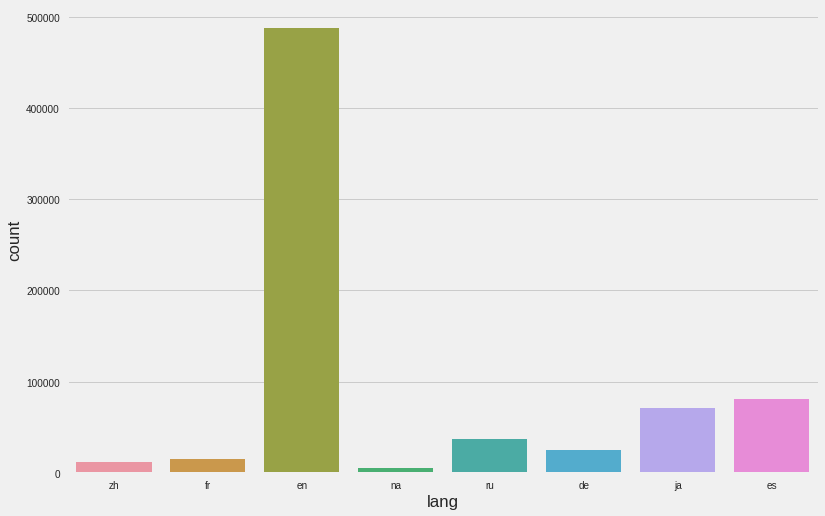

In [56]:
sns.countplot(test.lang)

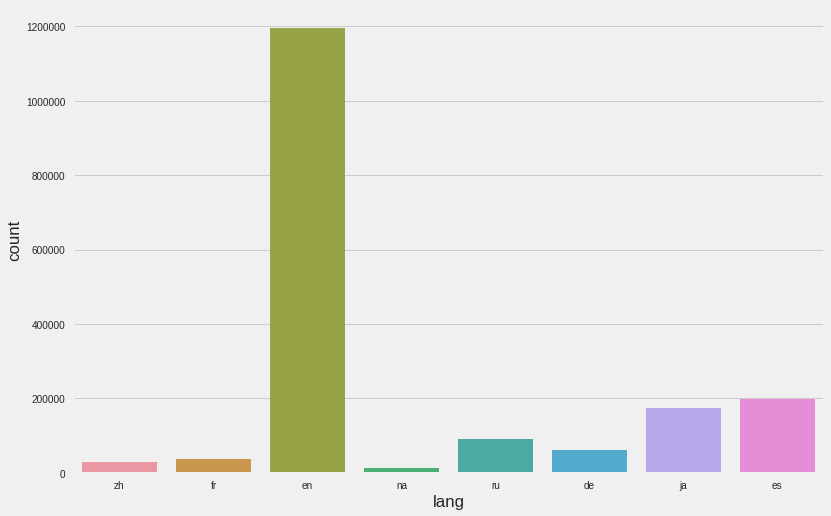

In [61]:
sns.countplot(new_train.lang)

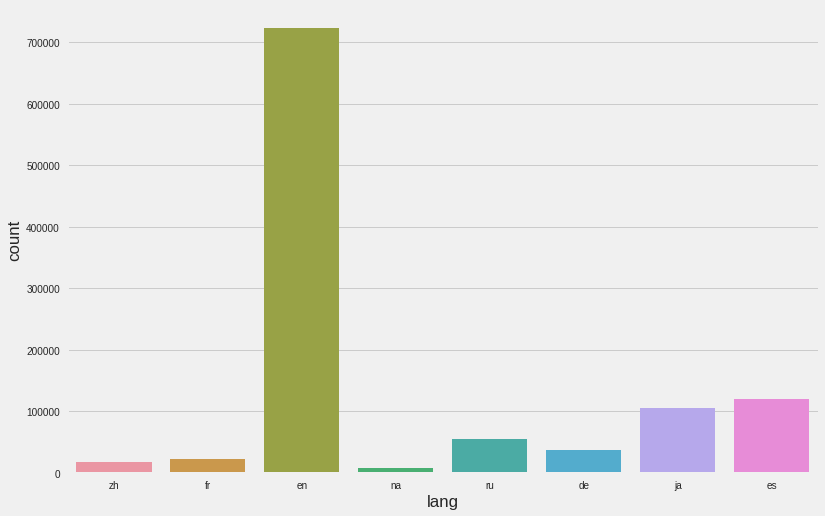

In [62]:
sns.countplot(holdout.lang)

In [131]:
from dateutil.relativedelta import relativedelta
def median_last_n_days(train, validation, n_days=15):
    last_day = train['date'].max()
    train = train.loc[train['date'] > (last_day - relativedelta(days=n_days))].copy()
    median_pred = train.groupby(['Page']).median().reset_index()
    median_pred.rename(columns={"Visits": "pred_Visits"}, inplace=True)
    
    return validation.merge(median_pred, on="Page", how='left')

def pandas_smape(df):
    df.fillna(0, inplace=True)
    df["SMAPE"] = 200 * np.abs(df["Visits"] - df["pred_Visits"]) / (df["Visits"] + df["pred_Visits"])
    df["SMAPE"].fillna(0, inplace=True)
    return np.mean(df["SMAPE"])

In [73]:
pandas_smape(median_last_n_days(new_train, holdout))

46.13493660921823

In [74]:
pandas_smape(median_last_n_days(new_train, test))

50.35649862558084

**3.** Perform K-fold validation using your type of split. Run GridSearch with any classificator you like and set of parameters to optimize, providing it with your custom validation.  Compare the score of your validation and test set. For scoring, again, use metrics SMAPE. In the google form write your scores on validation and test sets

In [126]:
def create_validation(df, start_date):
    return df.loc[(df['date'] >= pd.to_datetime(start_date) - relativedelta(days=0)) & \
                  (df['date'] <  pd.to_datetime(start_date) + relativedelta(months=3))].index, \
           df.loc[(df['date'] >= pd.to_datetime(start_date) + relativedelta(months=3)) & \
                  (df['date'] <  pd.to_datetime(start_date) + relativedelta(months=5))].index
    
train_dates = ['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01']

In [127]:
myCViterator = []
for i in train_dates:
    trainIndices, valIndices = create_validation(train, i)
    myCViterator.append( (trainIndices, valIndices) )

In [128]:
for x,y in myCViterator:
    print (min(x), min(y))

0 1075165
366265 1429615
708900 1795880
1075165 2150330
1429615 2516595


In [130]:
scores = []
for train_indexes, val_indexes in myCViterator:
    validation_pred = median_last_15_days(train.iloc[train_indexes].copy(), 
                                           train.iloc[val_indexes].copy())
    score = pandas_smape(validation_pred)
    scores.append(score)
    
scores, np.mean(scores)

([41.461029722192855,
  39.352658930775114,
  42.99083903077996,
  41.016810453820206,
  33.35887754746252],
 39.636043137006126)

In [136]:
params_score = {}
for n in [7, 14, 15, 20, 25, 30]:
    score_n_days = []
    for train_indexes, val_indexes in myCViterator:
        validation_pred = median_last_n_days(train.iloc[train_indexes].copy(), 
                                               train.iloc[val_indexes].copy(), n)
        score = pandas_smape(validation_pred)
        score_n_days.append(score)
    params_score[n] = np.mean(score_n_days)
    
params_score

{7: 39.16048152443817,
 14: 39.56268141160986,
 15: 39.636043137006126,
 20: 39.87943868041115,
 25: 40.22069571653397,
 30: 40.660659426005864}

In [99]:
pandas_smape(median_last_15_days(train, test))

40.007012702044406

## French house insurance prediction (MAPE metric)

**1.** Take a look carefuly at train and test dataset. Note for you what is the difference in them and how they are dependent. You may use any tool you like, any EDA you want. Decribe your validation and reason for your choice in google form.

**2.** 
+ Implement your validation. 
+ Generate additional features. 
+ Build a model you like/you can. 
+ Wait for training your model. If it takes too much time, listen to https://www.youtube.com/watch?v=XWkGL4eZR3E
+ Submit your scores on validation and test to google form. Use MAPE metric for scoring. 
+ Ланфрен ланфра лантатита

In [137]:
train = pd.read_csv('../../data/train_french.csv')
test = pd.read_csv('../../data/test_french.csv')

In [149]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 29 columns):
code_postal          200000 non-null int64
nb_pieces            200000 non-null int64
veranda              200000 non-null object
biens_nomades        200000 non-null int64
sit_fam              200000 non-null object
profession           200000 non-null object
nature_lri           200000 non-null object
societe              200000 non-null int64
domaine_activite     200000 non-null int64
niv_urbanisation     200000 non-null object
age_societaire       200000 non-null int64
objets_precieux      200000 non-null int64
pres_contrat_auto    200000 non-null int64
formule              200000 non-null int64
sit_juridique        200000 non-null int64
surf_habitat         200000 non-null int64
patrimoine_mob       200000 non-null int64
var1                 200000 non-null int64
var2                 200000 non-null int64
var3                 200000 non-null int64
var4                 200

In [110]:
test.head()

,code_postal,nb_pieces,veranda,biens_nomades,sit_fam,profession,nature_lri,societe,domaine_activite,niv_urbanisation,...,var3,var4,var5,var6,var7,var8,var9,var10,var11,prime_tot_ttc
0,6029,5,OUI,500,Famille,agent; employe,Maison,1,7,C,...,0,164,41,0,0,1,NON,30,1,107.94
1,62128,2,NON,0,Famille,enseignant; formateur; chercheur,Appartement,1,1,D,...,1,85,100,0,0,1,NON,30,2,80.41
2,81065,4,NON,1000,Indivividu,homme ou femme au foyer,Sans information,2,99,~,...,0,94,100,0,0,1,NON,30,2,142.12
3,5023,3,NON,500,Indivividu,agent; employe,Maison,2,38,C,...,0,101,100,0,0,5,NON,30,2,76.55
4,62178,2,NON,500,Famille,enseignant; formateur; chercheur,Appartement,1,1,~,...,1,125,100,1,0,1,NON,0,2,150.45


In [139]:
profile = pp.ProfileReport(train)
profile.to_file(outputfile="statistic_train_french.html")

In [140]:
profile = pp.ProfileReport(test)
profile.to_file(outputfile="statistic_test_french.html")

In [141]:
def mape_score(y_true, y_pred):
    return np.sum(100. / y_true.shape[0] * np.abs((y_true - y_pred) / y_true))

In [142]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train.drop('prime_tot_ttc', axis=1), 
                                                   train['prime_tot_ttc'],
                                                   test_size=0.15, 
                                                   random_state=42)

In [146]:
import lightgbm as lgb

In [150]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_val, y_val, reference=lgb_train)

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

In [ ]:
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(test.drop('prime_tot_ttc', axis=1))

In [ ]:
mape_score(np.array(y_val), y_val_pred), mape_score(np.array(test['prime_tot_ttc']), y_test_pred)